In [129]:
import pandas as pd
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf, adfuller, coint
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM, VECMResults, CointRankResults, select_coint_rank
import statsmodels.api as sm
from scipy.stats import skew, kurtosis
from arch.unitroot import engle_granger
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from IPython.display import Markdown, Latex

# Table of Contents
1. [Data](#data)
    * [Descriptive statistics](#Descriptive_statistics)
    * [Graphs](#Graphs)
    * [Auto-Correlation coefficients](#Auto-Correlation)
2. [Statistical Tests](#statistical)
    * [Augmented Dickey-Fuller unit root tests](#ADF)
    * [Ordinary Leasr Square Regression](#OLS)
    * [Error Correction Models](#ECM)
        * [Engle Granger Test and Johansen Test](#EG&JT)
        * [Results for the B&K Regression Model](#BnK_regression)
        * [Results for the Vector Error Correction Model](#Results_VECM)
            * [One Cointegrating Vector](#One_Cointegrating_Vector)
            * [Three Cointegrating Vector](#Three_Cointegrating_Vector)
3. [Comparison of model prediction](#prediction)

In [130]:
raw_data = pd.read_excel('D:/Xin/Program/carry_model/CU.xlsx')

print(raw_data.head())
print(raw_data.tail())

        date  cash_price  futures_price  inventory  interest_rate
0 2009-12-31       59125          60020     597640         1.5066
1 2010-01-04       59975          60030     597715         1.5113
2 2010-01-05       59950          60590     600665         1.5213
3 2010-01-06       61025          61630     602715         1.5355
4 2010-01-07       61025          61170     602790         1.5610
           date  cash_price  futures_price  inventory  interest_rate
2547 2020-06-29       48770          48380     321646         2.1144
2548 2020-06-30       48770          48790     316571         2.1750
2549 2020-07-01       49450          49350     313296         2.1276
2550 2020-07-02       49460          49410     310671         2.0976
2551 2020-07-03       49260          48900     320693         2.0976


In [131]:
raw_data.loc[:, 'interest_rate_CCR'] = raw_data.loc[:, 'interest_rate'].apply(lambda x: 100 * math.log(1 + x / 100))
raw_data.loc[:, 'diff_interest_rate_CCR'] = raw_data.loc[:, 'interest_rate_CCR'].diff()

raw_data.loc[:, 'log_inventory'] = raw_data.loc[:, 'inventory'].apply(lambda x: math.log(x))
raw_data.loc[:, 'diff_log_inventory'] = raw_data.loc[:, 'log_inventory'].diff()

raw_data.loc[:, 'log_cash_price'] = raw_data.loc[:, 'cash_price'].apply(lambda x: math.log(x))
raw_data.loc[:, 'diff_log_cash_price'] = raw_data.loc[:, 'log_cash_price'].diff()

raw_data.loc[:, 'log_futures_price'] = raw_data.loc[:, 'futures_price'].apply(lambda x: math.log(x))
raw_data.loc[:, 'diff_log_futures_price'] = raw_data.loc[:, 'log_futures_price'].diff()

raw_data.loc[:, 'std_return_20d'] = raw_data.loc[:, 'diff_log_cash_price'].rolling(20).std()
raw_data.loc[:, 'diff_std_return_20d'] = raw_data.loc[:, 'std_return_20d'].diff()

raw_data.loc[:, 'autocorr_return_20d'] = raw_data.loc[:, 'diff_log_cash_price'].rolling(20).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data.loc[:, 'diff_autocorr_return_20d'] = raw_data.loc[:, 'autocorr_return_20d'].diff()

raw_data.loc[:, 'log_futures_less_log_cash'] = raw_data.loc[:, 'log_futures_price'] - raw_data.loc[:, 'log_cash_price']

# 1. Data<a name="data"></a>

In [132]:
def des_stat(x, level):
    sub_df = pd.DataFrame(data={'Mean': [np.mean(x)], 'S.D.': [np.std(x)], 'Skewness': [skew(x)], 'Kurtosis': [kurtosis(x)]}, index=[level])
    
    return sub_df

table_1 = pd.DataFrame()
for level in ['interest_rate', 'interest_rate_CCR', 'inventory', 'log_inventory', 'cash_price', 'log_cash_price', 'futures_price', 'log_futures_price', 'std_return_20d', 'autocorr_return_20d']:
    x = raw_data.loc[:, level].fillna(0).values
    sub_df = des_stat(x, level)
    table_1 = table_1.append(sub_df)
    

## 1.1 Descriptive statistics<a name="Descriptive_statistics"></a>: 
    see Table 1 for daily observations of 'SHFE CU'
    

In [133]:
print('Table 1: Descriptive statistics')    
print(table_1)

Table 1: Descriptive statistics
                              Mean           S.D.  Skewness  Kurtosis
interest_rate             2.791027       0.622591 -0.097801 -0.475459
interest_rate_CCR         2.750953       0.605889 -0.111594 -0.467892
inventory            476544.208856  130387.103268  0.429321  0.320887
log_inventory            13.035425       0.284414 -0.419533  0.123282
cash_price            50830.474922    8515.321380  0.425359  0.166710
log_cash_price           10.822308       0.167278 -0.057445 -0.101740
futures_price         50742.644984    8622.675509  0.478858  0.197364
log_futures_price        10.820259       0.168941 -0.004874 -0.116923
std_return_20d            0.009389       0.004651  1.545051  3.170396
autocorr_return_20d      -0.031739       0.185260  0.019196  0.119663


## 1.2 Graphs<a name="Graphs"></a>: 
    
    see Fig1 - Fig5

<AxesSubplot:title={'center':'Fig5'}, xlabel='date'>

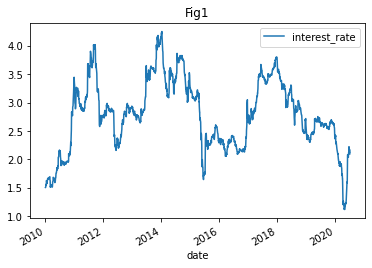

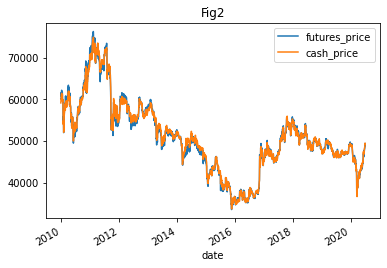

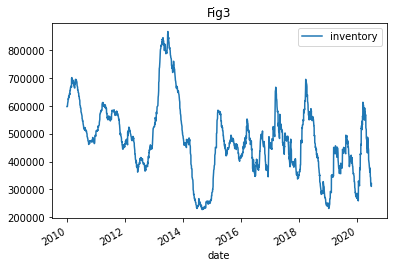

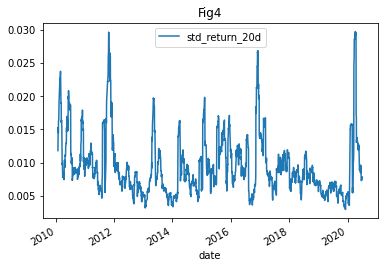

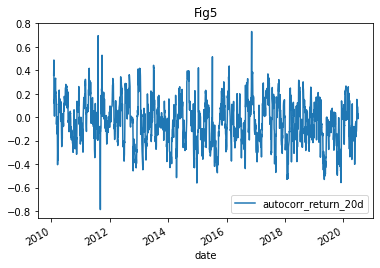

In [134]:
raw_data.plot(x='date', y=['interest_rate'], title='Fig1')
raw_data.plot(x='date', y=['futures_price', 'cash_price'], title='Fig2')
raw_data.plot(x='date', y=['inventory'], title='Fig3')
raw_data.plot(x='date', y=['std_return_20d'], title='Fig4')
raw_data.plot(x='date', y=['autocorr_return_20d'], title='Fig5')

In [135]:
def auto_corr(x, level):
    r1 = x.autocorr(lag=1)  
    r2 = x.autocorr(lag=2)  
    r3 = x.autocorr(lag=3)  
    r4 = x.autocorr(lag=4)  
    r5 = x.autocorr(lag=5)  
    r12 = x.autocorr(lag=12)  
    r24 = x.autocorr(lag=24)  
    sub_df = pd.DataFrame(data= {'r1': [r1], 'r2': [r2], 'r3': [r3], 'r4': [r4], 'r5': [r5], 'r12': [r12], 'r24': [r24], }, index=[level])
    
    return sub_df

table_2 = pd.DataFrame()
for level in ['interest_rate_CCR',  'diff_interest_rate_CCR', 'log_inventory', 'diff_log_inventory', 'log_cash_price', 'diff_log_cash_price', 'log_futures_price', 'diff_log_futures_price', 'std_return_20d', 'diff_std_return_20d', 'autocorr_return_20d','diff_autocorr_return_20d']:
    x = raw_data.loc[:, level].fillna(0)
    sub_df = auto_corr(x, level)
    table_2 = table_2.append(sub_df)
    

## 1.3 Auto-Correlation coefficients<a name="Auto-Correlation"></a>:
    
    reported in Table 2 for each of the variables

In [136]:
print('Table 2: Auto correlation over levels and change in levels')    
print(table_2)

Table 2: Auto correlation over levels and change in levels
                                r1        r2        r3        r4        r5  \
interest_rate_CCR         0.998276  0.995455  0.992012  0.988212  0.984175   
diff_interest_rate_CCR    0.317088  0.178536  0.102148  0.065858  0.056651   
log_inventory             0.997658  0.994661  0.991294  0.987629  0.983823   
diff_log_inventory        0.140045  0.078151  0.062502  0.029146  0.255173   
log_cash_price            0.998014  0.995870  0.993591  0.991302  0.988965   
diff_log_cash_price       0.040051  0.033799  0.003523  0.012139 -0.001419   
log_futures_price         0.997335  0.994956  0.992413  0.989818  0.987303   
diff_log_futures_price   -0.053495  0.030344  0.010367 -0.015738  0.006972   
std_return_20d            0.977860  0.953202  0.924630  0.894432  0.862553   
diff_std_return_20d       0.045157  0.089003  0.041951  0.038771 -0.005310   
autocorr_return_20d       0.885263  0.803311  0.727433  0.668979  0.600099   
diff_

# 2. Statistical Tests <a name="Statistical Tests"></a> 

In [137]:
var_dic = {'interest rate (C.C.R.)': ['interest_rate_CCR',  'diff_interest_rate_CCR'], 'natural log of the inventory': ['log_inventory', 'diff_log_inventory'], 'natural log of the cash price': ['log_cash_price', 'diff_log_cash_price'], 'natural log of futures price': ['log_futures_price', 'diff_log_futures_price'], 'cash price return std': [ 'std_return_20d', 'diff_std_return_20d'], 'cash price return 1-order auto-corr coef': ['autocorr_return_20d','diff_autocorr_return_20d']} 

table_3 = pd.DataFrame()

for key in var_dic:
    key_list = var_dic[key]
    levels_1_lag = round(adfuller(x=raw_data.loc[:, key_list[0]].fillna(0).values, maxlag=1, regression='ct')[0], 2)
    levels_2_lag = round(adfuller(x=raw_data.loc[:, key_list[0]].fillna(0).values, maxlag=2, regression='ct')[0], 2)
    levels_4_lag = round(adfuller(x=raw_data.loc[:, key_list[0]].fillna(0).values, maxlag=4, regression='ct')[0], 2)
    change_in_levels_1_lag = round(adfuller(x=raw_data.loc[:, key_list[1]].fillna(0).values, maxlag=1, regression='ct')[0], 2)
    change_in_levels_2_lag = round(adfuller(x=raw_data.loc[:, key_list[1]].fillna(0).values, maxlag=2, regression='ct')[0], 2)
    change_in_levels_4_lag = round(adfuller(x=raw_data.loc[:, key_list[1]].fillna(0).values, maxlag=4, regression='ct')[0], 2)
    
    sub_df = pd.DataFrame(data=[[levels_1_lag, levels_2_lag, levels_4_lag, change_in_levels_1_lag, change_in_levels_2_lag, change_in_levels_4_lag]], index=[key])

    table_3 = table_3.append(sub_df)

columns=[('Levels', '1 lag'), ('Levels', '2 lags'), ('Levels', '4 lags'), ('Change in Levels', '1 lag'), ('Change in Levels', '2 lags'), ('Change in Levels', '4 lags')]
table_3.columns = pd.MultiIndex.from_tuples(columns)

## 2.1 Augmented Dickey-Fuller unit root tests<a name="ADF"></a>: 

    including both intercept and trend, reported in Table 3


In [138]:
print('Table 3: unit root test----augumented Dickey-Fuller test statistic')    
print(table_3)

Table 3: unit root test----augumented Dickey-Fuller test statistic
                                         Levels                \
                                          1 lag 2 lags 4 lags   
interest rate (C.C.R.)                    -2.49  -2.63  -2.63   
natural log of the inventory              -2.12  -2.25  -2.36   
natural log of the cash price             -1.91  -1.98  -1.98   
natural log of futures price              -2.03  -2.10  -2.10   
cash price return std                     -5.96  -6.50  -6.96   
cash price return 1-order auto-corr coef -11.19 -11.19 -10.61   

                                         Change in Levels                
                                                    1 lag 2 lags 4 lags  
interest rate (C.C.R.)                             -27.06 -27.06 -27.06  
natural log of the inventory                       -31.15 -25.33 -15.85  
natural log of the cash price                      -33.86 -33.86 -33.86  
natural log of futures price              

## 2.2 Ordinary Least Square Regression: <a name="OLS"></a>

    The results of regressions based on Eqn.(1) and (2) reported in Table 4 

$$ DP_t = a_0 + a_1 DF_{t|t-1} + e_t \tag{1} $$
$$ DP_t = b_0 + b_1 (F_{t|t-1} - P_{t-1}) + e_t \tag{2} $$

In [139]:
y_1 = raw_data.loc[:, 'diff_log_cash_price'].values[2:]
X_1 = raw_data.loc[:, 'diff_log_futures_price'].shift(1).values[2:]
X_1 = sm.add_constant(X_1)
model_1 = sm.OLS(y_1, X_1)
results_1 = model_1.fit()
print('Table 4: OLS Regression' + '\n' + 'Panel A: Regression of cash price change on the lagged futures price change')
print(results_1.summary(xname=['intercept', 'diff_log_futures_price'], yname='diff_log_cash_price'))


Table 4: OLS Regression
Panel A: Regression of cash price change on the lagged futures price change
                             OLS Regression Results                            
Dep. Variable:     diff_log_cash_price   R-squared:                       0.055
Model:                             OLS   Adj. R-squared:                  0.055
Method:                  Least Squares   F-statistic:                     147.9
Date:                 Mon, 07 Dec 2020   Prob (F-statistic):           3.99e-33
Time:                         10:49:53   Log-Likelihood:                 8062.4
No. Observations:                 2550   AIC:                        -1.612e+04
Df Residuals:                     2548   BIC:                        -1.611e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------

In [140]:
y_2 = raw_data.loc[:, 'diff_log_cash_price'].values[2:]
X_2 = raw_data.loc[:, 'log_futures_less_log_cash'].shift(1).values[2:]
X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(y_2, X_2)
results_2 = model_2.fit()
print('Panel B: Regression of cash price change on lagged difference between futures price and cash price')
print(results_2.summary(xname=['intercept', 'log_futures_less_log_cash'], yname='diff_log_cash_price'))

Panel B: Regression of cash price change on lagged difference between futures price and cash price
                             OLS Regression Results                            
Dep. Variable:     diff_log_cash_price   R-squared:                       0.046
Model:                             OLS   Adj. R-squared:                  0.046
Method:                  Least Squares   F-statistic:                     124.0
Date:                 Mon, 07 Dec 2020   Prob (F-statistic):           3.79e-28
Time:                         10:49:53   Log-Likelihood:                 8051.0
No. Observations:                 2550   AIC:                        -1.610e+04
Df Residuals:                     2548   BIC:                        -1.609e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-------

<font size="3">
Remark： These results of regressions based on Eqs. (1) and (2) offer a base case for comparison as they replicate the early tests of the ability of futures price to predict cash price. Both slope parameters are significantly different from zero. Before error correction models can be estimated, we have to identify the number of cointegrating vectors that exists between the variables, future prices, cash prices, interest rate, inventory, cash price return standard deviation and cash price return first order auto-correlation coefficient.

## 2.3 Error Correction Models: <a name="ECM"></a>
    
As is known in the thesis, the Brenner and Kroner (1995) correction model can be written as:
    
$$ DP_t = g_0 + g_1 DF_{t|t-1} + g_2 Dr_{t|t-1} + g_3 DI_{t-1} + g_4 D\sigma_{t-1} + g_5 D\rho(1)_{t-1} + g_6 ECT_{t-2} + e_t \tag{6} $$

The error correction term, $ECT_{t-2}$ is the residual, $e_{t-1}$ from the regression:

$$ P_{t-1} = h_0 + h_1 F_{t-1|t-2} + h_2 r_{t-1|t-2} + h_3I_{t-2} + h_4 \sigma_{t-2} + h_5\rho(1)_{t-2} + e_{t-1} \tag{7} $$

with $g_i$ and $h_i$ as estimated parameters. Rearranging Eqs.(6) provides the more traditional form of the error correction model
    
$$ DP_t = i_0 + i_1 DF_{t|t-1} + i_2 DP_{t|t-1} + i_3 Dr_{t|t-1} + i_4 I_{t-1} + i_5 D\sigma_{t-1} + i_6 D\rho(1)_{t-1} + i_7 ECT_{t-2}^{*} + e_t \tag{8} $$

The error correction term, $ECT^{*}_{t-2}$ or cost of carry pricing discrepancy, is the residual, $e_{t-1}$ from the regression:
$$ P_{t-2} = j_0 + j_1 F_{t-1|t-2} + j_2 r_{t-1|t-2} + j_3I_{t-2} + j_4 \sigma_{t-2} + j_5\rho(1)_{t-2} + e_{t-1} \tag{9} $$
with $i_i$ and $j_i$ as estimated parameters.

### 2.3.1 Engle Granger Test and Johansen Test: <a name="EG&JT"></a>
    
    Augmented Dickey-Fuller tests are reported for the Engle-Granger cointegration test with statistics for three lag choices, 1 lag, 2lags, 4lags, see Table 5, Panel A. In all cases, the null of no cointegration is rejected in favor of the alternative of cointegration, though this test provides little indication of whether there is more than cointegrating vector. 

    Panel B of Table 5 identifies THREE cointegrating vectors in the system using either the Trace statistic or the Maximal value statistic.


In [141]:
data = raw_data.dropna(axis=0)

y_log_P = data.loc[:, 'log_cash_price'].values[1:]
X_BK = data.loc[:, ['log_futures_price', 'interest_rate', 'log_inventory', 'std_return_20d', 'autocorr_return_20d']].shift(periods=1, axis=0).values[1:]
X_Std = data.loc[:, ['log_futures_price', 'interest_rate', 'log_inventory', 'std_return_20d', 'autocorr_return_20d']].values[1:]


table_5_Panel_A = pd.DataFrame()
coin_vec_dic = {}
for key, value in {'BnK ECT': X_BK, 'Std ECT': X_Std}.items():  
    res_1_lag = engle_granger(y_log_P, value, trend='c', lags=1)
    t_stat_1_lag = res_1_lag.stat
    coin_vec_dic[key] = res_1_lag.cointegrating_vector
    critical_value = res_1_lag.critical_values[5]
    
    res_2_lags = engle_granger(y_log_P, value, trend='c', lags=2)
    t_stat_2_lags = res_2_lags.stat
    
    res_4_lags = engle_granger(y_log_P, value, trend='c', lags=4)
    t_stat_4_lags = res_4_lags.stat
    
    sub_df = pd.DataFrame(data=[[t_stat_1_lag, t_stat_2_lags, t_stat_4_lags]], index=[key])
    table_5_Panel_A = pd.concat([table_5_Panel_A, sub_df], axis=0)
    

In [142]:
data_test_johansen = pd.concat([pd.DataFrame(data=y_log_P, columns=['log_cash_price']), pd.DataFrame(data=X_BK, columns=['log_futures_price', 'interest_rate_CCR', 'log_inventory', 'std_return_20d', 'autocorr_return_20d'])], axis=1)

johansen_res = coint_johansen(data_test_johansen, det_order=0, k_ar_diff=1)
table_5_Panel_B = pd.DataFrame(columns=['Trace_statistic', 'CV_Trace_90pct', 'CV_Trace_95pct', 'CV_Trace_99pct', 'MaxEig_statistic', 'CV_MaxEig_90pct', 'CV_MaxEig_95pct', 'CV_MaxEig_99pct'], index=['rank = 0', 'rank <= 1', 'rank <= 2', 'rank <= 3', 'rank <= 4', 'rank <= 5']) 
table_5_Panel_B.loc[:, 'Trace_statistic'] = johansen_res.lr1
table_5_Panel_B.loc[:, 'MaxEig_statistic'] = johansen_res.lr2
table_5_Panel_B.loc[:, ['CV_Trace_90pct', 'CV_Trace_95pct', 'CV_Trace_99pct']] = johansen_res.cvt
table_5_Panel_B.loc[:, ['CV_MaxEig_90pct', 'CV_MaxEig_95pct', 'CV_MaxEig_99pct']] = johansen_res.cvm

In [143]:
print('Table 5: Test for coiintegration' + '\n')
print('Panel A: Engle and Granger test using the augumented Dickey-Fuller Test')
table_5_Panel_A.columns = ['1 lag', '2 lags', '4 lags']
print(table_5_Panel_A)
print('\n')
print('Panel B: Johansen test for cointegration vectors')
print(table_5_Panel_B)

vec_rank1 = select_coint_rank(data_test_johansen, det_order=0, k_ar_diff=1, method='trace', signif=0.05)
print(vec_rank1.summary())
vec_rank2 = select_coint_rank(data_test_johansen, det_order=0, k_ar_diff=1, method='maxeig', signif=0.05)
print(vec_rank2.summary())

Table 5: Test for coiintegration

Panel A: Engle and Granger test using the augumented Dickey-Fuller Test
             1 lag     2 lags     4 lags
BnK ECT -19.490954 -14.365833 -10.108119
Std ECT -12.857084 -10.001291  -7.557129


Panel B: Johansen test for cointegration vectors
           Trace_statistic  CV_Trace_90pct  CV_Trace_95pct  CV_Trace_99pct  \
rank = 0        462.628104         91.1090         95.7542        104.9637   
rank <= 1       189.032469         65.8202         69.8189         77.8202   
rank <= 2        61.053116         44.4929         47.8545         54.6815   
rank <= 3        20.478250         27.0669         29.7961         35.4628   
rank <= 4         9.691538         13.4294         15.4943         19.9349   
rank <= 5         3.627629          2.7055          3.8415          6.6349   

           MaxEig_statistic  CV_MaxEig_90pct  CV_MaxEig_95pct  CV_MaxEig_99pct  
rank = 0         273.595634          37.2786          40.0763          45.8662  
rank <= 1  

#### Remark(a):
    
    Statistically significant at the 5% level of significance with critical value at the 5% level of -4.71. Augmented Dickey Fuller tests are conducted on the residuals from the Brenner and Kroner model(B&K ECT), estimated using OLS:

In [144]:
para = - coin_vec_dic['BnK ECT']
Markdown("$P_t = %f + %f F_{t|t-1} + %f r_{t|t-1}+ %f I_{t|t-1} + %f \sigma_{t-1} + %f p(1)_{t-1} + e_t$"%(para[-1], para[1], para[2], para[3], para[4], para[5]))

$P_t = 0.223686 + 0.986308 F_{t|t-1} + 0.003813 r_{t|t-1}+ -0.006752 I_{t|t-1} + 0.417978 \sigma_{t-1} + 0.004778 p(1)_{t-1} + e_t$

<font size="3">
    
    and the standard error correction model (std ECT), estimated using OLS:

In [145]:
para = -coin_vec_dic['Std ECT']
Markdown("$P_t = %f + %f F_{t+1|t} + %f r_{t+1|t}+ %f I_{t+1|t} + %f \sigma_{t} + %f p(1)_{t} + e_t$"%(para[-1], para[1], para[2], para[3], para[4], para[5]))

$P_t = 0.208892 + 0.986720 F_{t+1|t} + 0.004069 r_{t+1|t}+ -0.005927 I_{t+1|t} + 0.297561 \sigma_{t} + 0.003271 p(1)_{t} + e_t$

#### Remark(b):
    
    The null hypothesis that there are less than or equal to 3 cointegration relations can not be rejected at 10% level of significance, either in trace method or maximal eigenvalue method.

In [146]:
# for key in coin_vec_dic:
#     print(key + ': Cointegration vector for 1 lag')
#     print(coin_vec_dic[key].rename({'y': 'log_cash_price', 'x1': 'log_futures_price', 'x2': 'interest_rate', 'x3': 'log_inventory', 'x4': 'std_return_20d', 'x5': 'autocorr_return_20d'}))
# print(johansen_res.eig)
# print(johansen_res.evec)
# co_r0t = johansen_res.r0t
# print(johansen_res.r0t)
# co_rkt = johansen_res.rkt
# print(johansen_res.rkt)

# eve = johansen_res.evec
# eve = eve / eve[0, :]
# eve = pd.DataFrame(data=eve, index=['log_cash_price', 'log_futures_price', 'interest_rate_CCR', 
#                                     'log_inventory', 'std_return_20d', 'autocorr_return_20d'])
# print(eve)

### 2.3.2 Results for the B&K Regression Model.<a name="BnK_regression"></a>
    
    First, we perform regression based on eqaution (7), the results are exhibited in Table 6, panel A. Although the slope parameters are significant for all varaibles, it is the spurious regression since the variables are non-stationary. We have to figure out the cointegration relationship in the six variables. Given the residual terms from regression based on equation (7), we do the difference method and add the error terms, to conduct the regression based on equation (6)  
    
    The results in panel B generally support the Brenner and Kronner(1995) argument that the costs of carrying the underlying asset have an impact on the cash price and thus on the ability of the current future price to predict cash prices.
    
    While the parameters for the futures price change is positive and statistically significant, the parameters for the change in inventory and th error correction term parameter are statistically significant and negative signed. This parameter estimates are consistent with the cost carry model. The results are also acceptable for interest rate and standard deviation in 10% significance level.

In [147]:
# get residuals
y_7 = data.loc[:, 'log_cash_price'].values[1:]
X_7 = data.loc[:, ['log_futures_price', 'interest_rate_CCR', 'log_inventory', 'std_return_20d', 'autocorr_return_20d']].shift(periods=1).values[1:]
X_7 = sm.add_constant(X_7)
model_7 = sm.OLS(y_7, X_7)
results_7 = model_7.fit()
print('Tbale 6: B&K model')
print('Panel A: based on equation (7)')
print(results_7.summary(yname='log_cash_price', xname=['intercept', 'log_futures_price', 'interest_rate_CCR', 'log_inventory', 'std_return_20d', 'autocorr_return_20d']))
residual = results_7.resid
data.loc[:, 'ECT'] = np.append(np.array([0]), residual[:])

Tbale 6: B&K model
Panel A: based on equation (7)
                            OLS Regression Results                            
Dep. Variable:         log_cash_price   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 8.376e+04
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        10:49:53   Log-Likelihood:                 7409.3
No. Observations:                2530   AIC:                        -1.481e+04
Df Residuals:                    2524   BIC:                        -1.477e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [148]:
y_6 = data.loc[:, 'diff_log_cash_price'].values[1:]
X_6 = data.loc[:, ['diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory','diff_std_return_20d', 'diff_autocorr_return_20d', 'ECT']].shift(1, axis=0).values[1:, :]
X_6 = sm.add_constant(X_6)
model_6 = sm.OLS(y_6, X_6)
results_6 = model_6.fit()
print('Table 6: B&K model')
print('Panel B: based on equation (6)')
print(results_6.summary(yname='diff_log_cash_price', xname=['intercept', 'diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory','diff_std_return_20d', 'diff_autocorr_return_20d', 'ECT']))

Table 6: B&K model
Panel B: based on equation (6)
                             OLS Regression Results                            
Dep. Variable:     diff_log_cash_price   R-squared:                       0.094
Model:                             OLS   Adj. R-squared:                  0.092
Method:                  Least Squares   F-statistic:                     43.50
Date:                 Mon, 07 Dec 2020   Prob (F-statistic):           8.44e-51
Time:                         10:49:53   Log-Likelihood:                 8063.0
No. Observations:                 2530   AIC:                        -1.611e+04
Df Residuals:                     2523   BIC:                        -1.607e+04
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [149]:
# xs = np.concatenate((y_7.reshape(len(y_7), 1), X_7[:, 2:]), axis=1)
# corr = np.corrcoef(xs, rowvar=False) 
# w, v = np.linalg.eig(corr)

In [150]:
# results_summary = results_6.summary(yname='diff_log_cash_price', xname=['intercept', 'diff_log_futures_price', 'diff_interest_rate', 'diff_log_inventory','diff_std_return_20d', 'diff_autocorr_return_20d', 'ECT'])
# results_as_html = results_summary.tables[1].as_html()
# pd.read_html(results_as_html, header=0, index_col=0)[0]

In [151]:
# check the unstability when there is uncontinuity in the data
# mod = sm.RecursiveLS(y_6, X_6[: , [1, 2, 3, 4, 5]])
# res = mod.fit()
# 
# print(res.summary())
# print(res.recursive_coefficients.filtered[0])
# res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(10,6))
# fig1 = res.plot_cusum(alpha=0.05)
# plt.show()
# fig2 = res.plot_cusum_squares(alpha=0.05)
# plt.show()

### 2.3.3 Results for the Vector Error Correction Model: <a name="Results_VECM"></a>
    
    Table 7 describes the vector error correction model with ONE cointegrating vector(Panel A) and THREE cointegrating vectors(Panel B). The simple one cointegrating vector model constrains the error correction term to the cost of carry relationship.

#### 2.3.3.1 One Cointegrating Vector: <a name="One_Cointegrating_Vector"></a>

In [152]:
data_vecm = data.loc[:, ['diff_log_cash_price', 'diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory', 'diff_std_return_20d', 'diff_autocorr_return_20d']]
model = VECM(data_vecm, deterministic='ci', k_ar_diff=1, coint_rank=1)
results = model.fit()

C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [153]:
coin_vector = pd.concat([pd.DataFrame(results.beta, index=['log_cash_price', 'log_futures_price', 'interest_rate_CCR', 'log_inventory', 'std_return_20d' , 'autocorr_return_20d'], columns=['cointegrating_vector']), 
                                      pd.DataFrame(results.det_coef_coint, index=['constant'], columns=['cointegrating_vector'])], axis=0)

gamma = pd.DataFrame(results.gamma)
gamma = gamma.round(3).T
gamma.index = ['L1.diff_log_cash_price', 'L1.diff_log_futures_price', 'L1.diff_interest_rate_CCR', 'L1.diff_log_inventory', 'L1.diff_std_return_20d' , 'L1.diff_autocorr_return_20d']
gamma.columns = ['diff_log_cash_price', 'diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory', 'diff_std_return_20d', 'diff_autocorr_return_20d']
alpha = pd.DataFrame(results.alpha) 
alpha = alpha.round(3).T
alpha.index = ['Error Correction Term']
alpha.columns = gamma.columns

df = pd.concat([gamma, alpha], axis=0)

tvalues_gamma = pd.DataFrame(results.tvalues_gamma)
tvalues_gamma = tvalues_gamma.round(3).T
tvalues_alpha = pd.DataFrame(results.tvalues_alpha)
tvalues_alpha = tvalues_alpha.round(3).T
tvalues = pd.concat([tvalues_gamma, tvalues_alpha], axis=0)

for i in range(0, 7):
    for j in range(0, 6):
        if np.abs(tvalues.iloc[i, j]) > 1.96:
            df.iloc[i, j] = str(df.iloc[i, j]) + "*" + " ({})".format(tvalues.iloc[i, j])
        else:
            df.iloc[i, j] = str(df.iloc[i, j]) + " ({})".format(tvalues.iloc[i, j])
            

In [154]:
print('Table 7: Cost of carry vector correction models')
print('Panel A: One cointegrating vector')
print(df)          

Table 7: Cost of carry vector correction models
Panel A: One cointegrating vector
                            diff_log_cash_price diff_log_futures_price  \
L1.diff_log_cash_price         -0.166* (-4.889)       -0.471* (-10.97)   
L1.diff_log_futures_price      -0.321* (-9.472)        -0.072 (-1.678)   
L1.diff_interest_rate_CCR         0.005 (0.904)           0.007 (1.06)   
L1.diff_log_inventory           -0.014 (-1.552)       -0.027* (-2.338)   
L1.diff_std_return_20d            0.644* (3.66)          0.276 (1.238)   
L1.diff_autocorr_return_20d         0.002 (1.2)        -0.001 (-0.675)   
Error Correction Term         -1.099* (-18.226)        0.857* (11.213)   

                            diff_interest_rate_CCR diff_log_inventory  \
L1.diff_log_cash_price             -0.058 (-0.519)     0.146* (2.193)   
L1.diff_log_futures_price            0.018 (0.158)     -0.11 (-1.655)   
L1.diff_interest_rate_CCR        -0.399* (-21.873)    -0.002 (-0.151)   
L1.diff_log_inventory            

#### Remark: 
*Statistically significant at the 5% level of significance. The t-statistic is reported in parentheses.The vector correction model takes the following form:

$$ DX_t =  M_1 DX_{t-1} + S^{'}ECT_{t-2}^{*} + L + E_t $$
$DX_t$ is the change in vector $X$, $M_1$ is the matrix of parameters, $S$ is the vector of speed of adjustment parameters, $L$ is a vector of constant terms and $E_t$ is the vector of residuals. $ECT^*_{t-2}$ are the residuals, $e_t$ from equation (9). The cointegrating vector is estimated as:
    

In [155]:
print(coin_vector)

                     cointegrating_vector
log_cash_price                   1.000000
log_futures_price               -0.936788
interest_rate_CCR                0.000745
log_inventory                    0.005928
std_return_20d                   0.309119
autocorr_return_20d              0.002349
constant                         0.000005


#### Remark
* Note that the coefficient of the error correction term for equation diff_log_cash_price is negative and strongly statistical significant, which is consitent with the regression result in Table 6, Panel B based on eqution (6)
* Focusing on the cash price equation, the statistical significant parameters appear a little inconsistent with the regression results in Table 6, Panel B. Both L1.diff_log_cash_price and L1.diff_log_future_price are statistical significant with VECM method, but the coefficient of L1.diff_log_cash_price is negagive. Furthermore, L1.diff_log_inventory is statistical significant with OLS method as shown in Table 6, Panel B, while L1.diff_std_return_20d is statistical significant with VECM method as shown in Table 7, Panel A.

In [156]:
print("Reference: the entire summaries are listed below")
print(results.summary())

Reference: the entire summaries are listed below
Det. terms outside the coint. relation & lagged endog. parameters for equation diff_log_cash_price
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.diff_log_cash_price         -0.1656      0.034     -4.889      0.000      -0.232      -0.099
L1.diff_log_futures_price      -0.3210      0.034     -9.472      0.000      -0.387      -0.255
L1.diff_interest_rate_CCR       0.0050      0.006      0.904      0.366      -0.006       0.016
L1.diff_log_inventory          -0.0139      0.009     -1.552      0.121      -0.032       0.004
L1.diff_std_return_20d          0.6438      0.176      3.660      0.000       0.299       0.989
L1.diff_autocorr_return_20d     0.0021      0.002      1.200      0.230      -0.001       0.005
Det. terms outside the coint. relation & lagged endog. parameters for equation diff_

#### 2.3.3.2 Three Cointegrating Vector: <a name="Three_Cointegrating_Vector"></a>

In [157]:
model = VECM(data_vecm, deterministic='ci', k_ar_diff=1, coint_rank=3)
results = model.fit()

C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [158]:
coin_vector = pd.concat([pd.DataFrame(results.beta, index=['log_cash_price', 'log_futures_price', 'interest_rate_CCR', 'log_inventory', 'std_return_20d' , 'autocorr_return_20d'], columns=['Cointegrating Vector 1', 'Cointegrating Vector 2', 'Cointegrating Vector 3']), pd.DataFrame(results.det_coef_coint, index=['constant'], columns=['Cointegrating Vector 1', 'Cointegrating Vector 2', 'Cointegrating Vector 3'])], axis=0)
coin_vector = coin_vector.round(3)

In [159]:
gamma = pd.DataFrame(results.gamma)
gamma = gamma.round(3).T
gamma.index = ['L1.diff_log_cash_price', 'L1.diff_log_futures_price', 'L1.diff_interest_rate_CCR', 'L1.diff_log_inventory', 'L1.diff_std_return_20d' , 'L1.diff_autocorr_return_20d']
gamma.columns = ['diff_log_cash_price', 'diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory', 'diff_std_return_20d', 'diff_autocorr_return_20d']
alpha = pd.DataFrame(results.alpha) 
alpha = alpha.round(3).T
alpha.index = ['Cointegrating Vector 1', 'Cointegrating Vector 2', 'Cointegrating Vector 3']
alpha.columns = gamma.columns

df = pd.concat([gamma, alpha], axis=0)

tvalues_gamma = pd.DataFrame(results.tvalues_gamma)
tvalues_gamma = tvalues_gamma.round(3).T
tvalues_alpha = pd.DataFrame(results.tvalues_alpha)
tvalues_alpha = tvalues_alpha.round(3).T
tvalues = pd.concat([tvalues_gamma, tvalues_alpha], axis=0)

for i in range(0, 9):
    for j in range(0, 6):
        if np.abs(tvalues.iloc[i, j]) > 1.96:
            df.iloc[i, j] = str(df.iloc[i, j]) + "*" + " ({})".format(tvalues.iloc[i, j])
        else:
            df.iloc[i, j] = str(df.iloc[i, j]) + " ({})".format(tvalues.iloc[i, j])

In [160]:
print('Table 7: Cost of carry vector correction models')
print('Panel B: Three cointegrating vector')
print(df)

Table 7: Cost of carry vector correction models
Panel B: Three cointegrating vector
                            diff_log_cash_price diff_log_futures_price  \
L1.diff_log_cash_price           0.112* (3.606)       -0.107* (-2.741)   
L1.diff_log_futures_price      -0.258* (-8.707)          0.009 (0.249)   
L1.diff_interest_rate_CCR       -0.003 (-0.667)        -0.003 (-0.573)   
L1.diff_log_inventory            0.09* (10.436)         0.11* (10.117)   
L1.diff_std_return_20d           0.942* (6.128)         0.666* (3.454)   
L1.diff_autocorr_return_20d       -0.0 (-0.148)        -0.005 (-1.801)   
Cointegrating Vector 1        -1.566* (-28.396)          0.247* (3.57)   
Cointegrating Vector 2          0.808* (16.166)      -1.093* (-17.433)   
Cointegrating Vector 3           0.01* (16.421)        0.014* (19.674)   

                            diff_interest_rate_CCR diff_log_inventory  \
L1.diff_log_cash_price             -0.093 (-0.789)     0.411* (6.026)   
L1.diff_log_futures_price    

#### Remark: 
*Statistically significant at the 5% level of significance. The t-statistic is reported in parentheses.The vector correction model takes the following form:

$$ DX_t =  M_1 DX_{t-1} + S^{'}ECT_{t-2}^{*} + L + E_t $$
$DX_t$ is the change in vector $X$, $M_1$ is the matrix of parameters, $S$ is the vector of speed of adjustment parameters, L is a vector of constant terms and $E_t$ are the error terms $e_t$, calculated using the cointegrating vectors associated with the three largest eigenvalues obtained from the Johansen Procedure. The cointegrating vectors are:

In [161]:
print(coin_vector)

                     Cointegrating Vector 1  Cointegrating Vector 2  \
log_cash_price                        1.000                  -0.000   
log_futures_price                    -0.000                   1.000   
interest_rate_CCR                    -0.000                   0.000   
log_inventory                         0.273                   0.284   
std_return_20d                        0.477                   0.124   
autocorr_return_20d                   0.099                   0.109   
constant                              0.000                   0.000   

                     Cointegrating Vector 3  
log_cash_price                       -0.000  
log_futures_price                    -0.000  
interest_rate_CCR                     1.000  
log_inventory                        -0.195  
std_return_20d                      -69.169  
autocorr_return_20d                   7.230  
constant                              0.000  


#### Remark
* Note that the speed of adjustment for all the three cointegraing vectors is statistical significant. The parameter of the first cointegrating vector that accords to the maximal eigvalue, has a negative sign, which is consistent with the carry model, though the parameters of the other two cointegrating vectors have the positive sign.
* Focusing on the cash price equation, there are four statistical significant parameters: L1.diff_log_cash_price, L1.diff_log_future_price, L1.diff_log_inventory and L1.diff_std_return_20d 

In [162]:
print("Reference: the entire summaries are listed below")
print(results.summary())

Reference: the entire summaries are listed below
Det. terms outside the coint. relation & lagged endog. parameters for equation diff_log_cash_price
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.diff_log_cash_price          0.1123      0.031      3.606      0.000       0.051       0.173
L1.diff_log_futures_price      -0.2585      0.030     -8.707      0.000      -0.317      -0.200
L1.diff_interest_rate_CCR      -0.0032      0.005     -0.667      0.504      -0.013       0.006
L1.diff_log_inventory           0.0903      0.009     10.436      0.000       0.073       0.107
L1.diff_std_return_20d          0.9421      0.154      6.128      0.000       0.641       1.243
L1.diff_autocorr_return_20d    -0.0003      0.002     -0.148      0.882      -0.005       0.004
Det. terms outside the coint. relation & lagged endog. parameters for equation diff_

In [163]:
# Gamma = results.gamma
# results.alpha
# results.plot()
# results.beta
# results.plot_acorr()

In [164]:
data = data.reset_index(drop=True)
initial_index_2015 = data.loc[data.loc[:, 'date'] >= pd.Timestamp('2015-01-01'),:].iloc[[0], :].index[0]
initial_index_2016 = data.loc[data.loc[:, 'date'] >= pd.Timestamp('2016-01-01'),:].iloc[[0], :].index[0]
initial_index_2017 = data.loc[data.loc[:, 'date'] >= pd.Timestamp('2017-01-01'),:].iloc[[0], :].index[0]
initial_index_2018 = data.loc[data.loc[:, 'date'] >= pd.Timestamp('2018-01-01'),:].iloc[[0], :].index[0]
end_index = data.iloc[[-1], :].index[0]
year_dict = {'2015': initial_index_2015, '2016': initial_index_2016, '2017': initial_index_2017, '2018': initial_index_2018} 

In [165]:
compare_dict = {}
for keys, values in year_dict.items():
    compare_predictions = pd.DataFrame()
    for i in range(values, end_index + 1): # test
        data_train = data.loc[0: i - 1, :]
        data_test = data.loc[[i], :]
        date = data_test.loc[:, 'date'].values
        y_true = data_test.loc[:, ['diff_log_cash_price']].values[0][0]   
        
        # OLS based on equation (1)
        y_train_ols_1 = data_train.loc[:, 'diff_log_cash_price'].values[1:]
        x_train_ols_1 = data_train.loc[:, 'diff_log_futures_price'].shift(1).values[1:]
        x_train_ols_1 = sm.add_constant(x_train_ols_1)
        model_ols_1 = sm.OLS(y_train_ols_1, x_train_ols_1)
        results_ols_1 = model_ols_1.fit()
        x_test_ols_1 = data_train.loc[:, 'diff_log_cash_price'].values[-1]
        x_test_ols_1 = np.concatenate(([[1]], [[x_test_ols_1]]), axis=1)
        y_pred_ols_1 = results_ols_1.predict(x_test_ols_1)[0]
       
        # OLS based on equation (2)
        y_train_ols_2 = data_train.loc[:, 'diff_log_cash_price'].values[1:]
        x_train_ols_2 = data_train.loc[:, 'log_futures_less_log_cash'].shift(1).values[1:]
        x_train_ols_2 = sm.add_constant(x_train_ols_2)
        model_ols_2 = sm.OLS(y_train_ols_2, x_train_ols_2)
        results_ols_2 = model_ols_2.fit()
        x_test_ols_2 = data_train.loc[:, 'diff_log_cash_price'].values[-1]
        x_test_ols_2 = np.concatenate(([[1]], [[x_test_ols_2]]), axis=1)
        y_pred_ols_2 = results_ols_2.predict(x_test_ols_2)[0]

        # B&K regression model
        y_train_bnk_eqn7 = data_train.loc[:, 'log_cash_price'].values[1:]
        x_train_bnk_eqn7 = data_train.loc[:, ['log_futures_price', 'interest_rate_CCR', 'log_inventory', 'std_return_20d', 'autocorr_return_20d']].shift(periods=1).values[1:]
        x_train_bnk_eqn7 = sm.add_constant(x_train_bnk_eqn7)
        model_bnk_eqn7 = sm.OLS(y_train_bnk_eqn7, x_train_bnk_eqn7)
        results_bnk_eqn7 = model_bnk_eqn7.fit()
        residual_eqn7 = results_bnk_eqn7.resid
        data_train.loc[:, 'error_correction_term'] = np.append(np.array([0]), residual_eqn7)

        y_train_bnk_eqn6 = data_train.loc[:, 'diff_log_cash_price'].values[1:]
        x_train_bnk_eqn6 = data_train.loc[:, ['diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory','diff_std_return_20d', 'diff_autocorr_return_20d', 'error_correction_term']].shift(periods=1).values[1:, :]
        x_train_bnk_eqn6 = sm.add_constant(x_train_bnk_eqn6)
        model_bnk_eqn6 = sm.OLS(y_train_bnk_eqn6, x_train_bnk_eqn6)
        results_bnk_eqn6 = model_bnk_eqn6.fit()
        x_test_bnk_eqn6 = data_train.loc[:,['diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory','diff_std_return_20d', 'diff_autocorr_return_20d', 'error_correction_term']].values[-1,:]
        x_test_bnk_eqn6 = np.concatenate(([1], x_test_bnk_eqn6))
        y_pred_bnk_eqn6 = results_bnk_eqn6.predict(x_test_bnk_eqn6)[0]

        # VECM: one cointegrating vector 
        X_train_vecm_1cv = data_train.loc[:, ['diff_log_cash_price', 'diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory', 'diff_std_return_20d', 'diff_autocorr_return_20d']]
        model_vecm_1cv = VECM(X_train_vecm_1cv, deterministic='ci', k_ar_diff=1, coint_rank=1)
        results_vecm_1cv  = model_vecm_1cv.fit()
        y_pred_vecm_1cv = results_vecm_1cv.predict(steps=1)[0][0]

        # VECM: three cointegrating vector 
        X_train_vecm_3cv = data_train.loc[:, ['diff_log_cash_price', 'diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory', 'diff_std_return_20d', 'diff_autocorr_return_20d']]
        model_vecm_3cv = VECM(X_train_vecm_1cv, deterministic='ci', k_ar_diff=1, coint_rank=3)
        results_vecm_3cv  = model_vecm_3cv.fit()
        y_pred_vecm_3cv = results_vecm_3cv.predict(steps=1)[0][0]

        sub_pred_df = pd.DataFrame(data=np.array([y_true, y_pred_ols_1, y_pred_ols_2, y_pred_bnk_eqn6, y_pred_vecm_1cv, y_pred_vecm_3cv]).reshape((1, 6)), 
                                   columns=['y_true', 'y_pred_ols_1', 'y_pred_ols_2', 'y_pred_bnk_reg', 'y_pred_vecm_1cv', 'y_pred_vecm_3cv'], index=[date])
        compare_predictions = pd.concat([compare_predictions, sub_pred_df], axis=0)
    
    compare_dict[keys] = compare_predictions


C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [166]:
forecast_accuracy_dict = {}

for keys, values in compare_dict.items():
    compare_predictions = values
    num_observation = compare_predictions.shape[0]
    compare_predictions.loc[:, 'error_ols_1'] = compare_predictions.loc[:, 'y_true'] - compare_predictions.loc[:, 'y_pred_ols_1']
    compare_predictions.loc[:, 'error_ols_2'] = compare_predictions.loc[:, 'y_true'] - compare_predictions.loc[:, 'y_pred_ols_2']
    compare_predictions.loc[:, 'error_bnk_reg'] = compare_predictions.loc[:, 'y_true'] - compare_predictions.loc[:, 'y_pred_bnk_reg']
    compare_predictions.loc[:, 'error_vecm_1cv'] = compare_predictions.loc[:, 'y_true'] - compare_predictions.loc[:, 'y_pred_vecm_1cv']
    compare_predictions.loc[:, 'error_vecm_3cv'] = compare_predictions.loc[:, 'y_true'] - compare_predictions.loc[:, 'y_pred_vecm_3cv']

    mean_error_ols_1 = compare_predictions.loc[:, 'error_ols_1'].mean()
    mean_abs_error_ols_1 = compare_predictions.loc[:, 'error_ols_1'].abs().mean()
    mean_square_error_ols_1 = compare_predictions.loc[:, 'error_ols_1'].apply(lambda x : math.pow(x, 2)).mean()
    
    mean_error_ols_2 = compare_predictions.loc[:, 'error_ols_2'].mean()
    mean_abs_error_ols_2 = compare_predictions.loc[:, 'error_ols_2'].abs().mean()
    mean_square_error_ols_2 = compare_predictions.loc[:, 'error_ols_2'].apply(lambda x : math.pow(x, 2)).mean()
    
    mean_error_bnk_reg = compare_predictions.loc[:, 'error_bnk_reg'].mean()
    mean_abs_error_bnk_reg = compare_predictions.loc[:, 'error_bnk_reg'].abs().mean()
    mean_square_error_bnk_reg = compare_predictions.loc[:, 'error_bnk_reg'].apply(lambda x : math.pow(x, 2)).mean()
    
    mean_error_vecm_1cv = compare_predictions.loc[:, 'error_vecm_1cv'].mean()
    mean_abs_error_vecm_1cv = compare_predictions.loc[:, 'error_vecm_1cv'].abs().mean()
    mean_square_error_vecm_1cv = compare_predictions.loc[:, 'error_vecm_1cv'].apply(lambda x : math.pow(x, 2)).mean()
    
    mean_error_vecm_3cv = compare_predictions.loc[:, 'error_vecm_3cv'].mean()
    mean_abs_error_vecm_3cv = compare_predictions.loc[:, 'error_vecm_3cv'].abs().mean()
    mean_square_error_vecm_3cv = compare_predictions.loc[:, 'error_vecm_3cv'].apply(lambda x : math.pow(x, 2)).mean()
    
    forecast_accuracy = pd.DataFrame(data=np.array([[mean_error_ols_1, mean_abs_error_ols_1, mean_square_error_ols_1],
                                           [mean_error_ols_2, mean_abs_error_ols_2, mean_square_error_ols_2],
                                           [mean_error_bnk_reg, mean_abs_error_bnk_reg, mean_square_error_bnk_reg],
                                           [mean_error_vecm_1cv, mean_abs_error_vecm_1cv, mean_square_error_vecm_1cv],
                                           [mean_error_vecm_3cv, mean_abs_error_vecm_3cv, mean_square_error_vecm_3cv]]),
                                     index=['OLS-1', 'OLS-2', 'B&K', 'VECM-1CV', 'VECM-3CV'],
                                     columns=['Mean_Error', 'Mean_Absolute_Error', 'Mean_Square_Error'])
    forecast_accuracy = forecast_accuracy.round(6)
    for j in range(0, 3):
        arg_abs_min = np.argmin(np.abs(forecast_accuracy.iloc[:, j].values))
        forecast_accuracy.iloc[arg_abs_min, j] = str(forecast_accuracy.iloc[arg_abs_min, j]) + str('*')
    
    forecast_accuracy_dict[keys] = [forecast_accuracy, num_observation]


In [167]:
print('Table 8: One step ahead rate of return forecast accuracy')
print('Panel A: model fitted from 2010 to 2014, forecast out of sample 2015 to 2020(' + str(forecast_accuracy_dict['2015'][1]) 
      + ' observations), rolling window' )
print(forecast_accuracy_dict['2015'][0])

print('Panel B: model fitted from 2010 to 2015, forecast out of sample 2016 to 2020(' + str(forecast_accuracy_dict['2016'][1]) 
      + ' observations), rolling window' )
print(forecast_accuracy_dict['2016'][0])

print('Panel C: model fitted from 2010 to 2016, forecast out of sample 2017 to 2020(' + str(forecast_accuracy_dict['2017'][1]) 
      + ' observations), rolling window' )
print(forecast_accuracy_dict['2017'][0])

print('Panel D: model fitted from 2010 to 2017, forecast out of sample 2018 to 2020(' + str(forecast_accuracy_dict['2018'][1]) 
      + ' observations), rolling window' )
print(forecast_accuracy_dict['2018'][0])


Table 8: One step ahead rate of return forecast accuracy
Panel A: model fitted from 2010 to 2014, forecast out of sample 2015 to 2020(1339 observations), rolling window
         Mean_Error Mean_Absolute_Error Mean_Square_Error
OLS-1      0.000121            0.007221          0.000114
OLS-2     -0.000391            0.007194          0.000114
B&K       -0.000771           0.006672*           0.0001*
VECM-1CV     2e-06*            0.007957          0.000128
VECM-3CV   0.000178            0.007012          0.000107
Panel B: model fitted from 2010 to 2015, forecast out of sample 2016 to 2020(1095 observations), rolling window
         Mean_Error Mean_Absolute_Error Mean_Square_Error
OLS-1      0.000288            0.006887          0.000105
OLS-2     -0.000205            0.006863          0.000105
B&K       -0.000499            0.00637*          9.2e-05*
VECM-1CV   2.7e-05*            0.007589          0.000116
VECM-3CV   0.000258            0.006762            0.0001
Panel C: model fitted f

<AxesSubplot:>

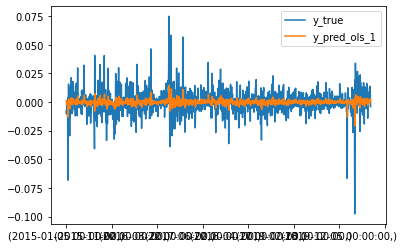

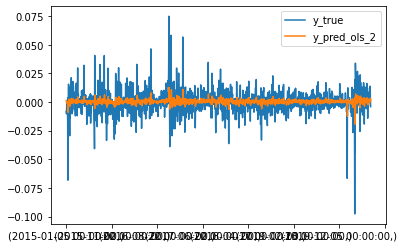

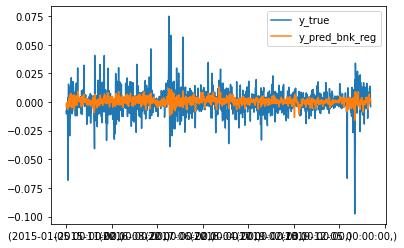

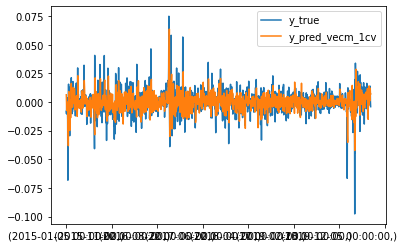

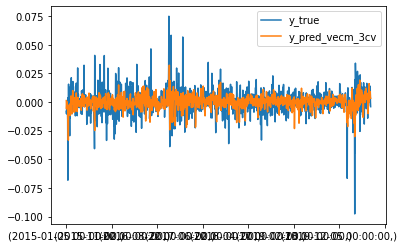

In [172]:
df_2015 = compare_dict['2015']
df_2015[['y_true', 'y_pred_ols_1']].plot()
df_2015[['y_true', 'y_pred_ols_2']].plot()
df_2015[['y_true', 'y_pred_bnk_reg']].plot()
df_2015[['y_true', 'y_pred_vecm_1cv']].plot()
df_2015[['y_true', 'y_pred_vecm_3cv']].plot()

<AxesSubplot:xlabel='date'>

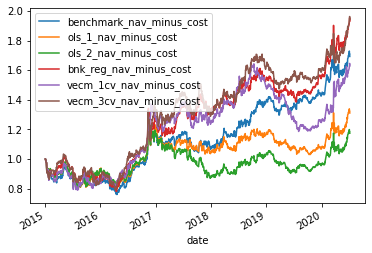

In [176]:
df_2015_pred = df_2015.reset_index()
df_2015_pred.rename(columns={'level_0': 'date'}, inplace=True)

df_2015_pred = df_2015_pred.loc[:, ['date', 'y_pred_ols_1', 'y_pred_ols_2', 'y_pred_bnk_reg', 'y_pred_vecm_1cv', 'y_pred_vecm_3cv']] 
df_2015_pred.loc[:, ['y_pred_ols_1', 'y_pred_ols_2', 'y_pred_bnk_reg', 'y_pred_vecm_1cv', 'y_pred_vecm_3cv']] = df_2015_pred.loc[:, ['y_pred_ols_1', 'y_pred_ols_2', 'y_pred_bnk_reg', 'y_pred_vecm_1cv', 'y_pred_vecm_3cv']].shift(-1)

df_2015_pred.iloc[-1, 1:] = 0
df_prices = raw_data.loc[:, ['date', 'cash_price', 'futures_price', 'log_futures_less_log_cash']]
df_prices.loc[:, 'price_change_pct'] = df_prices.loc[:, 'futures_price'].pct_change(periods=1)

df_port = pd.merge(df_2015_pred.loc[:,['date', 'y_pred_ols_1', 'y_pred_ols_2', 'y_pred_bnk_reg', 'y_pred_vecm_1cv', 'y_pred_vecm_3cv']], 
                   df_prices, how='inner', on='date')
df_port_1 = df_port.copy()

def get_net_value(df, pos_col):
    df.loc[:, pos_col[4:] +'_rtn'] = np.append(np.array([0]), np.roll(df.loc[:, pos_col].fillna(0), 1)[1:]) * df.loc[:, 'price_change_pct']
    df.loc[:, pos_col[4:] +'_turnover'] = np.append(np.array([0]), np.diff(df.loc[:, pos_col].fillna(0)))
    df.loc[:, pos_col[4:] + '_rtn_minus_cost'] = (df.loc[:, pos_col[4:] + '_rtn'] - df.loc[:, pos_col[4:] + '_turnover'].abs() * 0.0003).fillna(0)
    df.loc[:, pos_col[4:] + '_nav'] = (1 + df.loc[:, pos_col[4:] + '_rtn'].values).cumprod()
    df.loc[:, pos_col[4:] + '_nav_minus_cost'] = (1 + df.loc[:, pos_col[4:] + '_rtn_minus_cost'].values).cumprod()
    vmax = np.maximum.accumulate(df.loc[:, pos_col[4:] + '_nav_minus_cost'])
    df.loc[:, pos_col[4:] + '_mdd'] = df.loc[:, pos_col[4:] + '_nav_minus_cost'] / vmax - 1
    return df
    
df_port_1.loc[:, 'pos_benchmark'] = - np.sign(df_port_1.loc[:, 'log_futures_less_log_cash'].values)
df_port_1 = get_net_value(df_port_1, 'pos_benchmark') 

df_port_1.loc[:, 'modified_basis_ols_1'] = df_port_1.loc[:, 'y_pred_ols_1'] - df_port_1.loc[:, 'log_futures_less_log_cash']
df_port_1.loc[:, 'pos_ols_1'] = np.sign(df_port_1.loc[:, 'modified_basis_ols_1'])
df_port_1 = get_net_value(df_port_1, 'pos_ols_1') 

df_port_1.loc[:, 'modified_basis_ols_2'] = df_port_1.loc[:, 'y_pred_ols_2'] - df_port_1.loc[:, 'log_futures_less_log_cash']
df_port_1.loc[:, 'pos_ols_2'] = np.sign(df_port_1.loc[:, 'modified_basis_ols_2'])
df_port_1 = get_net_value(df_port_1, 'pos_ols_2') 

df_port_1.loc[:, 'modified_basis_bnk_reg'] = df_port_1.loc[:, 'y_pred_bnk_reg'] - df_port_1.loc[:, 'log_futures_less_log_cash']
df_port_1.loc[:, 'pos_bnk_reg'] = np.sign(df_port_1.loc[:, 'modified_basis_bnk_reg'])
df_port_1 = get_net_value(df_port_1, 'pos_bnk_reg') 

df_port_1.loc[:, 'modified_basis_vecm_1cv'] = df_port_1.loc[:, 'y_pred_vecm_1cv'] - df_port_1.loc[:, 'log_futures_less_log_cash']
df_port_1.loc[:, 'pos_vecm_1cv'] = np.sign(df_port_1.loc[:, 'modified_basis_vecm_1cv'])
df_port_1 = get_net_value(df_port_1, 'pos_vecm_1cv') 

df_port_1.loc[:, 'modified_basis_vecm_3cv'] = df_port_1.loc[:, 'y_pred_vecm_3cv'] - df_port_1.loc[:, 'log_futures_less_log_cash']
df_port_1.loc[:, 'pos_vecm_3cv'] = np.sign(df_port_1.loc[:, 'modified_basis_vecm_3cv'])
df_port_1 = get_net_value(df_port_1, 'pos_vecm_3cv') 

df_port_1.plot(x='date', y=['benchmark_nav_minus_cost', 'ols_1_nav_minus_cost', 'ols_2_nav_minus_cost', 'bnk_reg_nav_minus_cost',
         'vecm_1cv_nav_minus_cost', 'vecm_3cv_nav_minus_cost'])

<AxesSubplot:xlabel='date'>

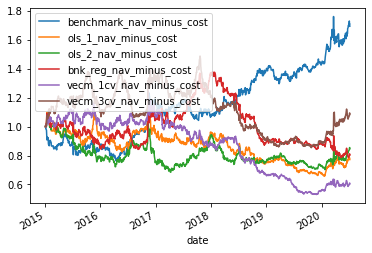

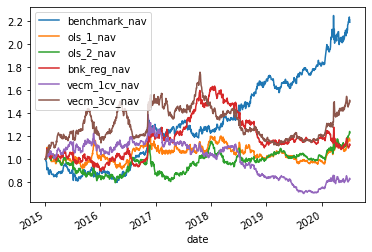

In [180]:
df_port_2 = df_port.copy()
df_port_2.loc[:, 'pos_benchmark'] = - np.sign(df_port_2.loc[:, 'log_futures_less_log_cash'].values)

df_port_2 = get_net_value(df_port_2, 'pos_benchmark') 

df_port_2.loc[:, 'pos_ols_1'] = np.sign(df_port_2.loc[:, 'y_pred_ols_1'])
df_port_2 = get_net_value(df_port_2, 'pos_ols_1') 

df_port_2.loc[:, 'pos_ols_2'] = np.sign(df_port_2.loc[:, 'y_pred_ols_2'])
df_port_2 = get_net_value(df_port_2, 'pos_ols_2') 

df_port_2.loc[:, 'pos_bnk_reg'] = np.sign(df_port_2.loc[:, 'y_pred_bnk_reg'])
df_port_2 = get_net_value(df_port_2, 'pos_bnk_reg') 

df_port_2.loc[:, 'pos_vecm_1cv'] = np.sign(df_port_2.loc[:, 'y_pred_vecm_1cv'])
df_port_2 = get_net_value(df_port_2, 'pos_vecm_1cv') 

df_port_2.loc[:, 'pos_vecm_3cv'] = np.sign(df_port_2.loc[:, 'y_pred_vecm_3cv'])
df_port_2 = get_net_value(df_port_2, 'pos_vecm_3cv') 

# df_port_1[['benchmark_nav_minus_cost', 'ols_1_nav_minus_cost', 'ols_2_nav_minus_cost', 'bnk_reg_nav_minus_cost',
#          'vecm_1cv_nav_minus_cost', 'vecm_3cv_nav_minus_cost']].plot()
df_port_2.plot(x='date', y=['benchmark_nav_minus_cost', 'ols_1_nav_minus_cost', 'ols_2_nav_minus_cost', 'bnk_reg_nav_minus_cost',
         'vecm_1cv_nav_minus_cost', 'vecm_3cv_nav_minus_cost'])
df_port_2.plot(x='date', y=['benchmark_nav', 'ols_1_nav', 'ols_2_nav', 'bnk_reg_nav',
         'vecm_1cv_nav', 'vecm_3cv_nav'])

In [186]:
futures_price_change_pct_dict = {}
for keys, values in year_dict.items():
    futures_price_change_pct = pd.DataFrame()
    for i in range(values, end_index + 1): # test
        data_train = data.loc[0: i - 1, :]
        data_test = data.loc[[i], :]
        date = data_test.loc[:, 'date'].values
        y_true = data_test.loc[:, ['diff_log_futures_price']].values[0][0]   
        
        # VECM: one cointegrating vector 
        X_train_vecm_1cv = data_train.loc[:, ['diff_log_cash_price', 'diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory', 'diff_std_return_20d', 'diff_autocorr_return_20d']]
        model_vecm_1cv = VECM(X_train_vecm_1cv, deterministic='ci', k_ar_diff=1, coint_rank=1)
        results_vecm_1cv  = model_vecm_1cv.fit()
        y_pred_vecm_1cv = results_vecm_1cv.predict(steps=1)[0][1]

        # VECM: three cointegrating vector 
        X_train_vecm_3cv = data_train.loc[:, ['diff_log_cash_price', 'diff_log_futures_price', 'diff_interest_rate_CCR', 'diff_log_inventory', 'diff_std_return_20d', 'diff_autocorr_return_20d']]
        model_vecm_3cv = VECM(X_train_vecm_1cv, deterministic='ci', k_ar_diff=1, coint_rank=3)
        results_vecm_3cv  = model_vecm_3cv.fit()
        y_pred_vecm_3cv = results_vecm_3cv.predict(steps=1)[0][1]

        sub_pred_df = pd.DataFrame(data=np.array([y_true, y_pred_vecm_1cv, y_pred_vecm_3cv]).reshape((1, 3)), 
                                   columns=['y_true', 'y_pred_vecm_1cv', 'y_pred_vecm_3cv'], index=[date])
        futures_price_change_pct = pd.concat([futures_price_change_pct, sub_pred_df], axis=0)
    
    futures_price_change_pct_dict[keys] = futures_price_change_pct

<AxesSubplot:xlabel='date'>

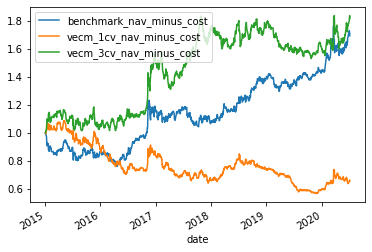

In [188]:
pred_future = futures_price_change_pct_dict['2015']
pred_future = pred_future.reset_index()
pred_future.rename(columns={'level_0': 'date'}, inplace=True)

pred_future = pred_future.loc[:, ['date', 'y_pred_vecm_1cv', 'y_pred_vecm_3cv']] 
pred_future.loc[:, ['y_pred_vecm_1cv', 'y_pred_vecm_3cv']] = pred_future.loc[:, ['y_pred_vecm_1cv', 'y_pred_vecm_3cv']].shift(-1)
pred_future.iloc[-1, 1:] = 0

df_prices = raw_data.loc[:, ['date', 'cash_price', 'futures_price', 'log_futures_less_log_cash']]
df_prices.loc[:, 'price_change_pct'] = df_prices.loc[:, 'futures_price'].pct_change(periods=1)
df_port_3 = pd.merge(pred_future, df_prices, how='inner', on='date')
# df_port_3.loc[:, 'price_change_pct'] = df_port_3.loc[:, 'y_true']

df_port_3.loc[:, 'pos_vecm_1cv'] = np.sign(df_port_3.loc[:, 'y_pred_vecm_1cv'].values)
df_port_3 = get_net_value(df_port_3, 'pos_vecm_1cv') 

df_port_3.loc[:, 'pos_vecm_3cv'] = np.sign(df_port_3.loc[:, 'y_pred_vecm_3cv'].values)
df_port_3 = get_net_value(df_port_3, 'pos_vecm_3cv') 

df_port_3.loc[:, 'pos_benchmark'] = - np.sign(df_port_3.loc[:, 'log_futures_less_log_cash'].values)
df_port_3 = get_net_value(df_port_3, 'pos_benchmark') 

df_port_3.plot(x='date', y=['benchmark_nav_minus_cost', 'vecm_1cv_nav_minus_cost', 'vecm_3cv_nav_minus_cost'])
#%

In [190]:
def index_1y(data, date):
    df = data.copy()
    current_index = df.loc[df.loc[:, 'date'] == date, :].index.tolist()[0]
    df.loc[:, 'date_yoy'] = df.loc[:, 'date'].apply(lambda x: (x - date).days)
    if df.loc[df.loc[:, 'date_yoy'] <= -365, :].shape[0] > 0:
        sub_df = df.loc[df.loc[:, 'date_yoy'] <= -365, :]
        index = sub_df.loc[(sub_df.loc[:, 'date_yoy'] + 365) == (sub_df.loc[:, 'date_yoy'] + 365).max(), :].index.tolist()[0]
        index_list = list(range(index, current_index + 1))
    else:
        index_list = np.nan

    return index_list


def quantile_1y(data, original_value):
    df = data.copy()
    df_notna = df.loc[df.loc[:, original_value].isna() == 0, :]
    df_notna.loc[:, 'df_index_1y'] = df_notna.loc[:, 'date'].apply(lambda x: index_1y(df_notna, x))
    quantile = df_notna.loc[df_notna.loc[:, 'df_index_1y'].isna() == 0, 'df_index_1y'].apply(lambda x: df_notna.loc[x[1:], original_value].rank(pct=True).values[-1])
    df.loc[df.loc[:, original_value].isna() == 0, 'quantile'] = quantile
    q = df.loc[:, 'quantile']

    return q

df_port_4 = df_port.copy()
df_port_4.loc[:, 'index_1y'] = df_port_4.loc[:, 'date'].apply(lambda x: index_1y(data, x))
df_port_4.loc[:, 'basis'] = - df_port_4.loc[:, 'log_futures_less_log_cash']

def get_pos(df, suffix, direction):  # 计算头寸
    df.loc[:, 'pos_' + suffix] = ((df.loc[:, suffix].values > 0.75).astype(int) - (df.loc[:, suffix].values < 0.25).astype(int)) * direction

    return df

df_port_4.loc[:, 'modified_basis_ols_1'] = df_port_4.loc[:, 'y_pred_ols_1'] + df_port_4.loc[:, 'basis']
df_port_4.loc[:, 'modified_basis_ols_2'] = df_port_4.loc[:, 'y_pred_ols_2'] + df_port_4.loc[:, 'basis']
df_port_4.loc[:, 'modified_basis_bnk_reg'] = df_port_4.loc[:, 'y_pred_bnk_reg'] + df_port_4.loc[:, 'basis']
df_port_4.loc[:, 'modified_basis_vecm_1cv'] = df_port_4.loc[:, 'y_pred_vecm_1cv'] + df_port_4.loc[:, 'basis']
df_port_4.loc[:, 'modified_basis_vecm_3cv'] = df_port_4.loc[:, 'y_pred_vecm_3cv'] + df_port_4.loc[:, 'basis']

In [191]:
for key in ['basis', 'modified_basis_ols_1', 'modified_basis_ols_2', 'modified_basis_bnk_reg', 'modified_basis_vecm_1cv', 'modified_basis_vecm_3cv']:
    df_port_4.loc[:, 'quantile_1y_' + key] = quantile_1y(df_port_4, 'basis')
    df_port_4 = get_pos(df_port_4, 'quantile_1y_' + key, 1)
    df_port_4 = get_net_value(df_port_4, 'pos_' + 'quantile_1y_' + key)


C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\envs\my_deep_learning\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
C